### PROJECT ABSTRACT 

With all the code computed on other notebookes:

 **1- Spotify API** - where I did my first connection to the API, providing it with like and disliked songs, as well as my musical journey data.

 **2- EDA** - where I explored all Spotify features based on the two groups in study.

 **3- My Musical Journey** - also a kind of EDA notebook. However, in this one I analysed my top year playlists to evaluate the evolution of my music taste from 2016 to 2019. 

 **4- Supervised ML** - tested multiple suprevised learning classifiers getting to a 86% Accuracy with Random Forest. I have now a pretty good algorithm that aimns to detect if I like a song or not, as well as the prob of that event happening.

 **5- Test on other's playlists** - used the best algorithm evaluated on ML notebook and applied to outside data - songs from friend's playlists - meaning neither data from the traning nor the test set.

 **6- Unsupervised Learning** - without any song labeling, used the whole dataset (liked + disliked songs) to extract knowledge based on any patterns: Clustering, Dimensionality Reduction.

Finally, in this script I aim to produce a final product where the user can input his/hers/theirs **(public) playlsit URI** and get an  **Exploratory Data Analysis on the songs' features, as well as new song recomendations.** This will be produced based on Unsupervised Learning techniques, since we can assume the shared playlist will be a collection of liked songs and therefore we can't apply labelling techniques.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
%matplotlib inline
import plotly.express as px

import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
import scipy.cluster.hierarchy as shc

from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
from IPython.display import display, Image, SVG, Math, YouTubeVideo


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
username = 'britopereiraa'
client_id ='17a3ed14ab434b33b28f19f8bea3337d'
client_secret = '7f848f9d2a024b15be5fa776b4dc7a05'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
def master_function(username, uri):
    uri = playlist_uri    
    username = username
    playlist_id = uri
    results = {'items':[]}

    for n in range(0,3000,100):
        new = sp.user_playlist_tracks(username, playlist_id,  offset = n)
        results['items'] += new['items']

        playlist_tracks_data = results
        playlist_tracks_id = []
        playlist_tracks_titles = []
        playlist_tracks_artists = []

        for track in playlist_tracks_data['items']:
            playlist_tracks_id.append(track['track']['id'])
            playlist_tracks_titles.append(track['track']['name'])

        #adds a list of all artists involved in the song to the list of artists for the playlist
            for artist in track['track']['artists']:
                artist_list = []
                artist_list.append(artist['name'])
            playlist_tracks_artists.append(artist_list[0])
    
    #some tracks might have none id
    playlist_tracks_id = list(filter(None, playlist_tracks_id)) 
    
    df = pd.DataFrame([])
    for i in range(0, len(playlist_tracks_id)):
        features = sp.audio_features(playlist_tracks_id[i])
        features_df = pd.DataFrame(features)
        df = df.append(features_df)
       

    df['title'] = playlist_tracks_titles
    #features_df['first_artist'] = playlist_tracks_first_artists
    df['main_artist'] = playlist_tracks_artists
    #features_df = features_df.set_index('id')
    df = df[['id', 'title', 'main_artist',
                               'danceability', 'energy', 'key', 'loudness',
                               'mode', 'acousticness', 'instrumentalness',
                               'liveness', 'valence', 'tempo',
                               'duration_ms', 'time_signature']]

    return df

### USER PLAYLIST

In [4]:
#input variables
playlist_uri ="2ERd3YQjKnGSEyInrwYPRh"
username = "João Fanha"

In [5]:
user_df = master_function(username,playlist_uri)
user_df.shape

(57, 15)

### Get the all songs playlist: 

A playlist with over 5000 songs of all Genre 

In [6]:
features = ['danceability', 'energy', 'key','loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

#import dataset created in other jupyter notebook
all_songs = pd.read_csv('../data/all_songs.csv')

#drop duplicates
all_songs.drop_duplicates(subset ="id", keep = False, inplace = True)


#check recomended songs that are not in the playlist already:

all_songs = all_songs.loc[~((all_songs.id.isin(user_df['id']))),:]
all_songs.head()

id               title     main_artist  danceability  \
0  2aQ8NyRJcsQFgb8jwUil90        Que Bandeira          Evinha         0.755   
1  6d4KqeYESkFHMirUgE1Aa3              Não Vá        Tim Maia         0.658   
2  2OoOgl80tDTElnbMYfhJyH             Reggins  The Blackbyrds         0.645   
3  5voWjUklIhjnNQU5aZCIm4  Dreaming About You  The Blackbyrds         0.744   
4  2jHa1UWWuouaoFqE8I7W77    Never Let Her Go     David Gates         0.576   

   energy  key  loudness  mode  acousticness  instrumentalness  liveness  \
0   0.537    1   -10.679     1       0.75600          0.000003    0.3550   
1   0.741    2   -10.495     1       0.04430          0.001280    0.0603   
2   0.383    5   -16.549     0       0.00495          0.611000    0.0727   
3   0.292    4   -16.592     0       0.26500          0.095900    0.0738   
4   0.399    8   -14.764     1       0.23300          0.000022    0.1040   

   valence    tempo  duration_ms  time_signature  
0    0.811   93.393       149420               4  
1    0.928  103.283       307037               4  
2    0.943   97.238       244800               4  
3    0.881   96.366       352400               4  
4    0.621   84.049       188813               4

In [7]:
all_songs.shape

(7836, 15)

## Songs Recomendations

### Clustering

In [8]:
#features scaling 
scaler = StandardScaler()
scaler.fit(all_songs[features])

all_songs_features_scaled = scaler.transform(all_songs[features])

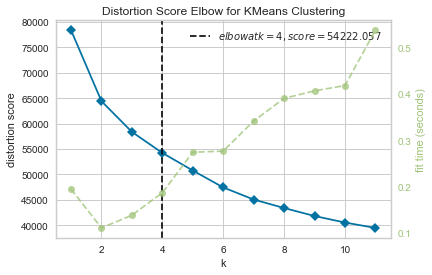

In [9]:
#TRAIN CLUSTERING IN ALL SONGS

X = all_songs_features_scaled
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [10]:
#label the data into clusters

kmean = KMeans(n_clusters=4)
kmean.fit(all_songs_features_scaled)

pred = kmean.labels_
all_songs['labels'] = pred

#check clusters
all_songs.head()

id               title     main_artist  danceability  \
0  2aQ8NyRJcsQFgb8jwUil90        Que Bandeira          Evinha         0.755   
1  6d4KqeYESkFHMirUgE1Aa3              Não Vá        Tim Maia         0.658   
2  2OoOgl80tDTElnbMYfhJyH             Reggins  The Blackbyrds         0.645   
3  5voWjUklIhjnNQU5aZCIm4  Dreaming About You  The Blackbyrds         0.744   
4  2jHa1UWWuouaoFqE8I7W77    Never Let Her Go     David Gates         0.576   

   energy  key  loudness  mode  acousticness  instrumentalness  liveness  \
0   0.537    1   -10.679     1       0.75600          0.000003    0.3550   
1   0.741    2   -10.495     1       0.04430          0.001280    0.0603   
2   0.383    5   -16.549     0       0.00495          0.611000    0.0727   
3   0.292    4   -16.592     0       0.26500          0.095900    0.0738   
4   0.399    8   -14.764     1       0.23300          0.000022    0.1040   

   valence    tempo  duration_ms  time_signature  labels  
0    0.811   93.393       149420               4       1  
1    0.928  103.283       307037               4       1  
2    0.943   97.238       244800               4       3  
3    0.881   96.366       352400               4       3  
4    0.621   84.049       188813               4       2

In [11]:
all_songs['labels'].value_counts()

1    2242
3    2234
2    1887
0    1473
Name: labels, dtype: int64

In [12]:
#APPLY CLUSTERS

df = user_df.copy()
pred_df = kmean.predict(df[features])
df['songs group'] = pred_df

df = df.reset_index()
df = df.drop(columns=['index'])
df.head()

id       title  main_artist  danceability  energy  key  \
0  1CsCuwscKV2tYqLeG0p8Q6  Toyota Man  Neon Indian         0.563   0.864    7   
1  6wYTcgNMqPZw2hybRMTEQf   Timebends   Deerhunter         0.369   0.796   10   
2  0uYRKUD994hbQi3JLSt22K    The Left     Duckwrth         0.808   0.703    7   
3  2uJT2q88v5RYhn5XRhAryM     Netflix        Malxs         0.720   0.504    4   
4  2pDKE8Q40TDGPl1O11DKKn    Shameika  Fiona Apple         0.375   0.776    8   

   loudness  mode  acousticness  instrumentalness  liveness  valence    tempo  \
0    -5.313     1        0.0685          0.000005    0.5160    0.896   93.901   
1    -8.236     1        0.2250          0.345000    0.2630    0.461  142.902   
2    -7.772     1        0.0636          0.005150    0.1050    0.392   90.003   
3    -7.658     1        0.1890          0.000000    0.1180    0.377   92.001   
4    -6.767     1        0.1540          0.000082    0.0925    0.647  186.814   

   duration_ms  time_signature  songs group  
0       252883               4            0  
1       758151               4            0  
2       263876               4            0  
3       159130               4            0  
4       248603               4            0

### PCA

In [13]:
#PCA on all songs

from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
df_pca_all_songs = pd.DataFrame(data=pca.fit_transform(all_songs_features_scaled), columns=['PC1','PC2','PC3'])

In [14]:
pca.components_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26459895 0.14200998 0.11470286]


Text(0, 0.5, 'Principal components')

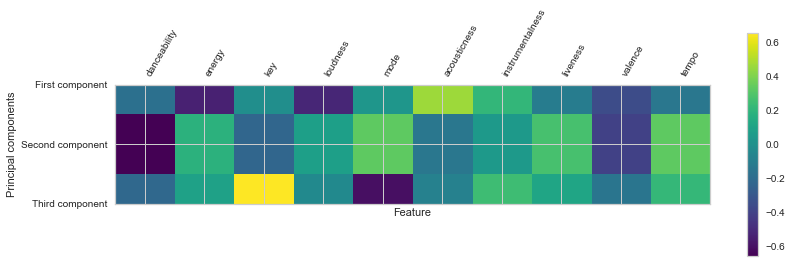

In [15]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1, 2], ["First component", "Second component", "Third component"])
plt.colorbar()
plt.xticks(range(len(all_songs[features].columns)),all_songs[features], rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

In [16]:
df_pca_all_songs = df_pca_all_songs.merge(all_songs, left_index=True, right_index=True)
df_pca_all_songs = df_pca_all_songs[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]

df_pca_all_songs.shape

(7737, 5)

In [17]:
#PCA with friend's playlist

#features scaling 
df_scaled = scaler.transform(df[features])

#use trained PCA
df_pca = pd.DataFrame(data=pca.transform(df_scaled), columns=['PC1','PC2','PC3'])

In [18]:
df_pca = df_pca.merge(df, left_index=True, right_index=True)
df_pca = df_pca[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]

df_pca.head()

PC1       PC2       PC3       title  main_artist
0 -2.229942  0.383929 -0.317573  Toyota Man  Neon Indian
1 -0.432322  1.615836  1.143230   Timebends   Deerhunter
2 -0.715839 -0.700782 -0.712597    The Left     Duckwrth
3  0.043131 -0.327809 -1.235401     Netflix        Malxs
4 -1.290093  1.578052  0.570986    Shameika  Fiona Apple

### Get recomendations with PCA and Nearest Neighbors

In [19]:
from scipy.spatial import KDTree
columns = ['PC1', 'PC2', 'PC3']

kdB = KDTree(df_pca_all_songs[columns].values)#all songs
neighbours = kdB.query(df_pca[columns].values, k=1)[-1]

print(neighbours)

#k desired number of neighbors: this case I chose 1 neighbour song
#returns indices of 1-neighbors for all rows/points in our songs "database"

[4342 2675 5125  493 7545 4062 1109 6505 4993 1914 5770 7666 6323 1469
 5540 3567  145 1682 7040  144 3462 2145 4076 4785 4785 6948 4868 6528
  803  391 6125 2475 4236 4332 4675 2520 2225 2119  656 2509 5706 2654
 5153 1664  113 3418 5402 6203 1678 4098 7169 4569   72 1608   20  847
 4099]


In [20]:
## recomendations output: 30 songs you might like
recomendations = all_songs[all_songs.index.isin(neighbours[:31])]

recomendations_output = recomendations[['title', 'main_artist']]
recomendations_output

title           main_artist
144                                 Morning Sunrise         Weldon Irvine
145                                     Secret Love         Shayna Steele
391                               We've Come So Far             Tom Misch
493                          Yo Yo Affair Pt. 1 & 2                Madlib
803     Everybody Loves The Sunshine - Original Mix              Kan Sano
1109                                     Here We Go         Roberta Flack
1469                              The Bug Collector     Haley Heynderickx
1682                                    Feed My Ego        Mickey Darling
1914  Ladies and Gentlemen We Are Floating in Space         Spiritualized
2145                                       "Juntos"               A Balsa
2675                            Paradise Architects          Theo Parrish
3462                                    All Mirrors           Angel Olsen
3567                                    Sleep Alone  Two Door Cinema Club
4062                                 Yumain O Leila                 Jadal
4076                                      Movin' Up                X-Wife
4342                                   BTSTU - Edit              Jai Paul
4785                                           Nara                 alt-J
4868                                           Oxum          Xênia França
4993                                          Salem              Bon Iver
5125                                   Symphonia IX          Current Joys
5540                                        Le Creo        Jowell & Randy
5770                                   Flow Batalla              NACHOSKY
6125                           Future Breed Machine             Meshuggah
6323                                  Mouth for War               Pantera
6505                                 Se A Casa Cair             Bandalusa
6528                                 És Tão Sensual                   Toy
6948                                  Electric Feel                  MGMT
7040                                   Early Flight               iamalex
7545                                      Graceland            Paul Simon
7666                                          Foulo      Orchestra Baobab

In [21]:
recomendations_output.shape

(30, 2)

## Exploratory Data Analysis

In [22]:
obamas = pd.read_csv('../data/obamas.csv')
pitchfork = pd.read_csv('../data/pitchfork.csv')
billboard = pd.read_csv('../data/billboard.csv')

In [23]:
obamas['Playlist'] = 'The Obamas'
pitchfork['Playlist'] = 'Pitchfork'
billboard['Playlist'] = 'Billboard Top 100'
user_df['Playlist'] = 'Your Songs'

In [24]:
frames = [billboard, pitchfork, obamas, user_df]

data = pd.concat(frames)
data = data.reset_index()
data = data.drop(columns=['index'])
data.head()

id                                              title  \
0  7ytR5pFWmSjzHJIeQkgog4                       ROCKSTAR (feat. Roddy Ricch)   
1  0VjIjW4GlUZAMYd2vXMi3b                                    Blinding Lights   
2  2MbdDtCv5LUVjYy9RuGTgC  WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil W...   
3  5v4GgrXPMghOnBBLmveLac                       Savage Remix (feat. Beyoncé)   
4  7fPuWrlpwDcHm5aHCH5D9t                              Roses - Imanbek Remix   

   main_artist  danceability  energy   key  loudness  mode  acousticness  \
0  Roddy Ricch         0.746   0.690  11.0    -7.956   1.0       0.24700   
1   The Weeknd         0.514   0.730   1.0    -5.934   1.0       0.00146   
2    Lil Wayne         0.904   0.723  11.0    -5.224   0.0       0.06310   
3      Beyoncé         0.822   0.743  10.0    -4.772   0.0       0.01600   
4      Imanbek         0.785   0.721   8.0    -5.457   1.0       0.01490   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.000000    0.1010    0.497   89.977     181733.0             4.0   
1          0.000095    0.0897    0.334  171.005     200040.0             4.0   
2          0.000000    0.1850    0.835  145.013     227478.0             4.0   
3          0.000000    0.1270    0.636   84.459     242001.0             4.0   
4          0.004320    0.2850    0.894  121.962     176219.0             4.0   

            Playlist  
0  Billboard Top 100  
1  Billboard Top 100  
2  Billboard Top 100  
3  Billboard Top 100  
4  Billboard Top 100

In [25]:
#scale
from sklearn.preprocessing import MinMaxScaler
# Min-max scaling

data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(data[features]), 
                         columns=data[features].columns)
data_scaled['Playlist'] = data['Playlist']

df_radar = data_scaled.groupby('Playlist').mean().reset_index() \
                    .melt(id_vars='Playlist', var_name="features", value_name="avg") \
                    .sort_values(by=['Playlist','features']).reset_index(drop=True)

fig = px.line_polar(df_radar, 
              r="avg", 
              theta="features", 
              title='Mean Values of Each Playlist Features',
              color="Playlist", 
              line_close=True,
              line_shape='spline',
              range_r=[0, 0.9],
              color_discrete_sequence=px.colors.cyclical.mygbm[:-6])

fig.show()

In [26]:
pdf_1 = fig.write_image("fig1.pdf")

image_1 = fig.write_image("image1.png")

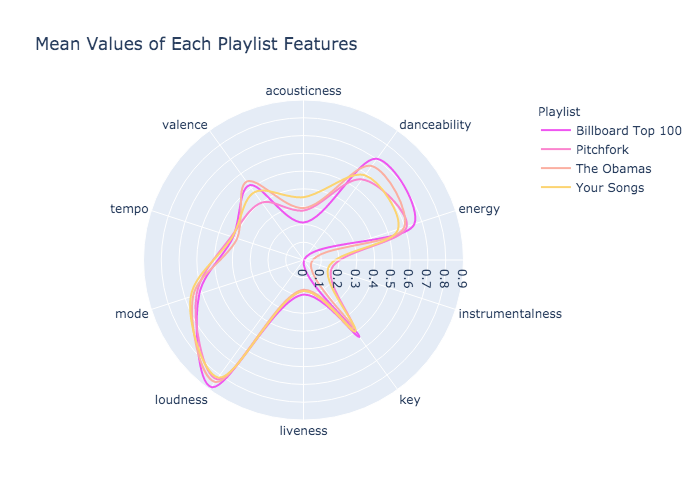

In [27]:
#because git doesn't load the graph above
Image(filename='image1.png',width = 1000)

In [28]:
playlists = list(data['Playlist'].unique())
playlists

['Billboard Top 100', 'Pitchfork', 'The Obamas', 'Your Songs']

In [29]:
print(features)

['danceability', 'energy', 'key', 'loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


## Hipster or Mainstream?

Let's compare your songs to Pitchfork best albums and best new music, as well as to Billboard week's Top 100 hits

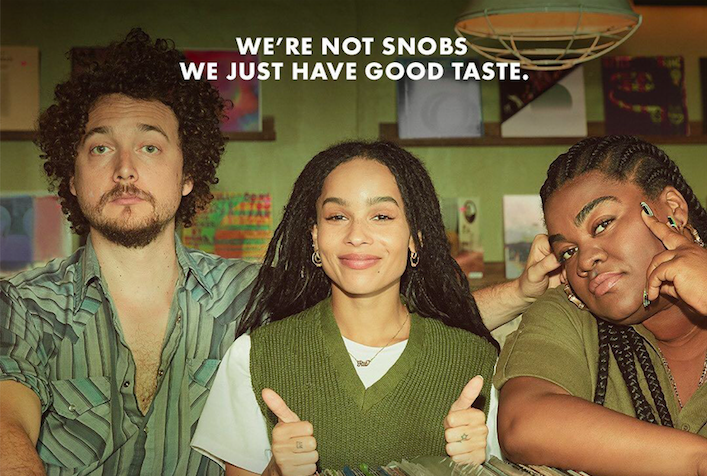

In [30]:
Image(filename='../images/new_highfid.png',width = 500)

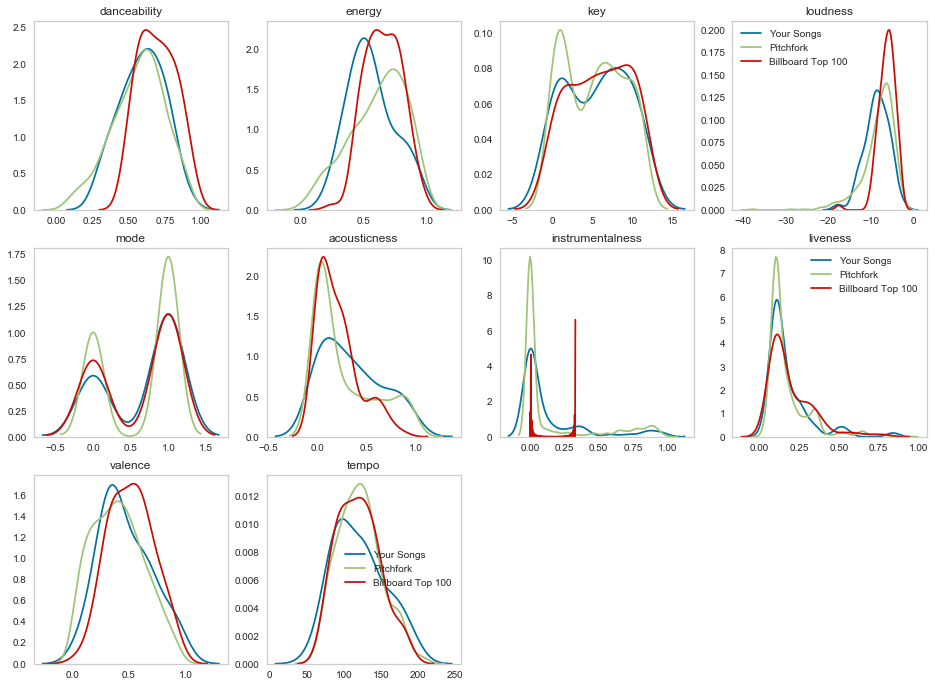

In [31]:
def big_graph(feature, label1="", label2="", label3 = ""):
    sns.kdeplot(data[data['Playlist']=='Your Songs'][feature],label=label1)
    sns.kdeplot(data[data['Playlist']=='Pitchfork'][feature],label=label2)
    sns.kdeplot(data[data['Playlist']=='Billboard Top 100'][feature],label=label3)
    
    plt.title(feature)
    plt.grid(b=None)

plots =[]    

plt.figure(figsize=(16,16))

for i, f in enumerate(features):
    plt.subplot(4,4,i+1)
    if ((i+1)% 4 == 0) or (i+1==len(features)):
        big_graph(f,label1="Your Songs", label2="Pitchfork", label3="Billboard Top 100")
    else:
        big_graph(f)

plots.append(plt.gca())

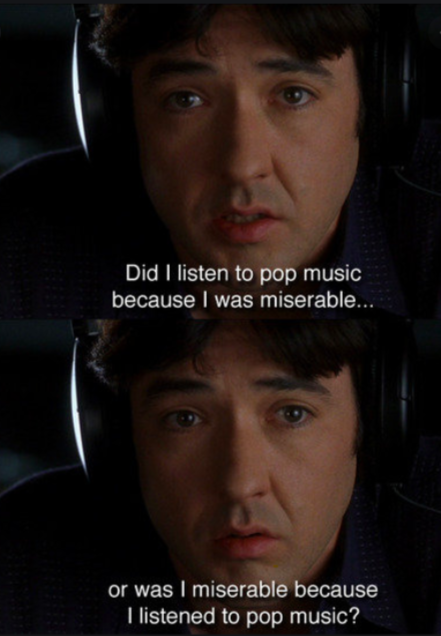

In [32]:
Image(filename='../images/old_highfid.png',width = 300)

## You a Obama?

Let's see if you got the musical taste of a Obama

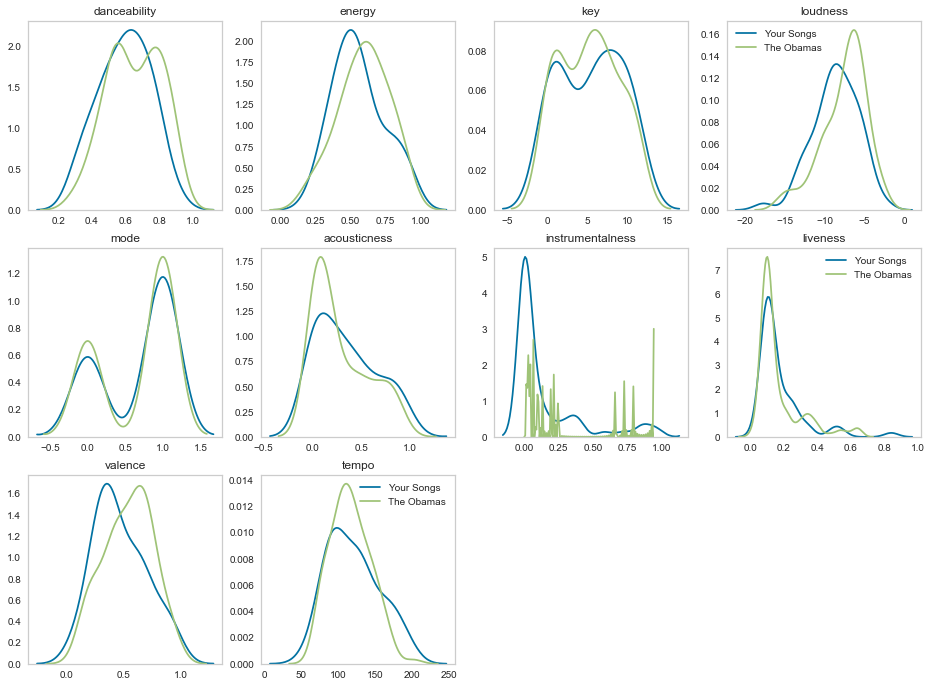

In [33]:
def big_graph2(feature, label1="", label2=""):
    sns.kdeplot(data[data['Playlist']=='Your Songs'][feature],label=label1)
    sns.kdeplot(data[data['Playlist']=='The Obamas'][feature],label=label2)
    plt.title(feature)
    plt.grid(b=None)

plt.figure(figsize=(16,16))


for i, f in enumerate(features):
    plt.subplot(4,4,i+1)
    if ((i+1)% 4 == 0) or (i+1==len(features)):
        big_graph2(f,label1="Your Songs", label2="The Obamas")
    else:
        big_graph2(f)
        
plots.append(plt.gca())

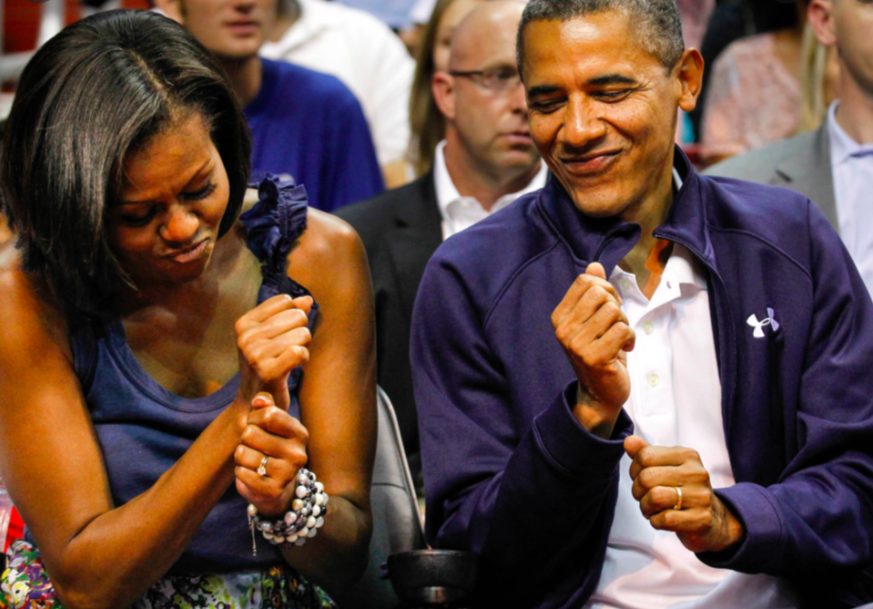

In [34]:
Image(filename='../images/obamas.png', width = 500)

## Create PDF


In [35]:
#create pdf with Graphs
from matplotlib.backends.backend_pdf import PdfPages
plotsFile = 'plots.pdf'

with PdfPages(plotsFile) as pdf:
    for f in plots:
        pdf.savefig(f.get_figure(),bbox_inches='tight',pad_inches=1)

In [37]:
#Add Poler Graph PDF

import PyPDF2 
 
# Open the files that have to be merged one by one
pdf1File = open('fig1.pdf', 'rb')
pdf2File = open('plots.pdf', 'rb')
 
# Read the files that you have opened
pdf1Reader = PyPDF2.PdfFileReader(pdf1File)
pdf2Reader = PyPDF2.PdfFileReader(pdf2File)
 
# Create a new PdfFileWriter object which represents a blank PDF document
pdfWriter = PyPDF2.PdfFileWriter()
 
# Loop through all the pagenumbers for the first document
for pageNum in range(pdf1Reader.numPages):
    pageObj = pdf1Reader.getPage(pageNum)
    pdfWriter.addPage(pageObj)
 
    # Loop through all the pagenumbers for the second document
for pageNum in range(pdf2Reader.numPages):
    pageObj = pdf2Reader.getPage(pageNum)
    pdfWriter.addPage(pageObj)
 
    #Now that you have copied all the pages in both the documents, write them into the a new document
pdfOutputFile = open('Ouput Report.pdf', 'wb')
pdfWriter.write(pdfOutputFile)
 
# Close all the files - Created as well as opened
pdfOutputFile.close()
pdf1File.close()
pdf2File.close()
